<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/qst_ml_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import os
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path= "/content/drive/MyDrive/SL_data/"
cvs_names = glob.glob(f'{path}*.csv')
data_list = []
for id, name in enumerate(cvs_names):
    data         = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    data_list.append(data)
dataset = np.stack(data_list)
print(dataset.shape)
X,y=dataset[:,:,:3],dataset[:,:,3:]


(100, 99, 5)


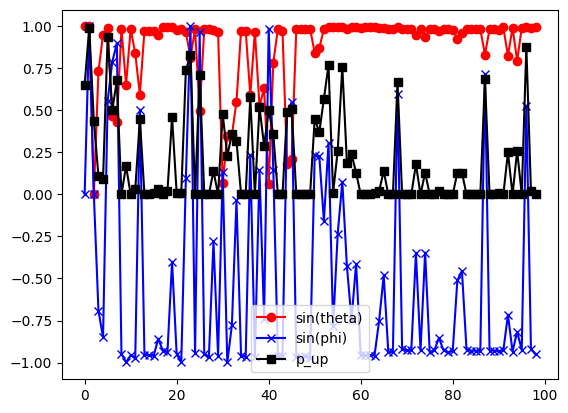

In [3]:
plt.plot(np.sin(X[1,:,0]),'o-r',label='sin(theta)')
plt.plot(np.sin(X[1,:,1]),'x-b',label='sin(phi)')
plt.plot(X[1,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [4]:
d_model   = 64  # Adjust this according to your needs
num_heads = 4  # Adjust this according to your needs


In [ ]:
# Information gain helper functions + examples

def information_gain(angles,bank_particles,weights):
    """
    Takes in angles as [theta,phi] and bank_particles and weigt as how they are given by the file. 
    """
    angle_dict={
        "theta":angles[0],
        "phi": angles[1]
    }
    best_guess=np.array(np.einsum('i...,i',bank_particles,weights))
    return adaptive_cost_func(angle_dict,bank_particles,weights,best_guess,1)       

def adaptive_cost_func(angles,rhoBank,weights,bestGuess,nQubits):
    """
    Computes the expected entropy reduction of the posterior (likelihood) distribution.
    The angles are taken in as a dictionary and indicate what mesaurement is to be perfomred.
    Noise correction is currently removed.  
    """
    # Crates projector from angles
    meshState=angles_to_state_vector(angles,nQubits)
    
    out=np.einsum('ij,ik->ijk',meshState,meshState.conj())
    # Computes the entropy of prior and posterior distributions. See 10.1103/PhysRevA.85.052120 for more details.
    K=Shannon_entropy(np.einsum('ijk,kj->i',out,bestGuess))
    J=Shannon_entropy(np.einsum('ijk,lkj->il',out,rhoBank))
    # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
    return np.real(K-np.dot(J,weights))

def Shannon_entropy(prob):
    """
    Returns the shannon entorpy of the probability histogram. 
    """
    return np.real(np.sum(-(prob*np.log2(prob)),axis=0))

def angles_to_state_vector(angles,nQubits):
    if nQubits==1:
        tempMesh=np.array([np.cos(angles["theta"]/2),np.exp(1j*angles["phi"])*np.sin(angles["theta"]/2)])
        meshState=np.array([tempMesh,get_opposing_state(tempMesh)])
    else:
        tempMeshA=np.array([np.cos(angles["thetaA"]/2),np.exp(1j*angles["phiA"])*np.sin(angles["thetaA"]/2)])
        tempMeshB=np.array([np.cos(angles["thetaB"]/2),np.exp(1j*angles["phiB"])*np.sin(angles["thetaB"]/2)])
        meshA=np.array([tempMeshA,get_opposing_state(tempMeshA)])
        meshB=np.array([tempMeshB,get_opposing_state(tempMeshB)])
        meshState=np.array([np.kron(meshA[0],meshB[0]),np.kron(meshA[0],meshB[1]),np.kron(meshA[1],meshB[0]),np.kron(meshA[1],meshB[1])])
    return meshState  

def get_opposing_state(meshState):
    """
    Returns orthogonal state vector for an arbitrary single qubit state vector (meshState).
    """
    # If the state is spin down it returns division by 0 error.
    if meshState[1]==0:
        return np.array([0, 1],dtype=complex)

    a=1
    b=-np.conjugate(meshState[0])/np.conjugate(meshState[1])
    norm=np.sqrt(a*np.conjugate(a) + b*np.conjugate(b))
    oppositeMeshState=np.array([a/norm, b/norm])
    return oppositeMeshState


# Example of how to run cost function

path= "SL_data/"
cvs_names=glob.glob(f'{path}*.csv')
bank_names=glob.glob(f'{path}*bank.npy')
weight_names=glob.glob(f'{path}*weights.npy')

# Example of loop that load from all file names
# for names in cvs_names:
#     with open(f'{names}','r') as f:
#         csvreader =csv.reader(f,delimiter=",")
#         data_list=list(csvreader)
#     #print(data_list)
# for name in bank_names:
#     bank=np.load(name,mmap_mode="r")
#     #print(bank)
# for name in weight_names:
#     weights=np.load(name,mmap_mode="r")
#     #print(weights)

# Select a single file
ind=0
with open(f'{cvs_names[ind]}','r') as f:
    csvreader =csv.reader(f,delimiter=",")
    data_list=list(csvreader)
bank=np.load(bank_names[ind],mmap_mode="r")  
weights=np.load(weight_names[ind],mmap_mode="r")
        
NN_angle_pred=np.array([1,0.5]) # Format as [ theta, phi ]


# Select which step in ABME to predict
prediction_index=50

true_angle=np.array([float(data_list[prediction_index][3]),float(data_list[prediction_index][4])])
true_info_gain=information_gain(true_angle,bank[prediction_index],weights[prediction_index])
NN_pred_info_gain=information_gain(NN_angle_pred,bank[prediction_index],weights[prediction_index])
print(f'Info gain difference: {true_info_gain-NN_pred_info_gain}')


# Test to see that step 10 to 60 works
for i in range(50):
    prediction_index=10 +i
    true_angle=np.array([float(data_list[prediction_index][3]),float(data_list[prediction_index][4])])
    true_info_gain=information_gain(true_angle,bank[prediction_index],weights[prediction_index])
    NN_pred_info_gain=information_gain(NN_angle_pred,bank[prediction_index],weights[prediction_index])
    #print(true_info_gain)
    #print(NN_pred_info_gain)
    print(true_info_gain-NN_pred_info_gain)

In [5]:
#class PermutationInvariantLayer(layers.Layer):
#    def __init__(self, **kwargs):
#        super(PermutationInvariantLayer, self).__init__(**kwargs)

#    def call(self, inputs):
#        # Assuming inputs has shape (batch_size, num_elements, num_features)
#        mean_across_elements = tf.reduce_mean(inputs, axis=1)
#        return mean_across_elements
'''
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self):
        super(PermutationInvariantLayer, self).__init__()
        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.attention = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=d_model // num_heads
            )
        self.flatten = layers.Flatten()  # Add a Flatten layer
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        flattened_output = self.flatten(attention_output)  # Flatten the output
        pooled_output = self.pooling(flattened_output)
        return pooled_output
'''

# Permutation Invariance
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self):
        super(PermutationInvariantLayer, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.attention = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=d_model // num_heads
            )
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        pooled_output    = self.pooling(attention_output)
        return pooled_output


In [28]:
#Define the custom probability function
def probability(y_pred):
    # Replace this with the actual logic
    p_out = tf.math.reduce_sum(y_pred, axis=1, keepdims=False, name=None)
    return p_out

def custom_loss(y_true, y_pred, lambda_weight=0.8):
    # Assuming y_true has shape (batch_size, 3) and y_pred has shape (batch_size, 2)
    y_true_values = y_true[:, :2]  # Extracting the target values from y_true
    y_pred_values = y_pred  # Adjust this based on your model's output structure


    # Assuming pro_true and pro_predict are the probabilities for comparison
    pro_true    = y_true[:, 2]
    pro_predict = probability(y_pred)  # Define how to get pro_predict from y_pred

    # Calculate MSE for target values
    mse_target = tf.keras.losses.mean_squared_error(y_true_values, y_pred_values)

    # Calculate MSE for probabilities
    mse_prob = tf.keras.losses.mean_squared_error(pro_true, pro_predict)

    # Combine both losses with an appropriate weighting factor
    total_loss = mse_target + lambda_weight * mse_prob

    return total_loss


In [29]:
# Example test case
batch_size = 32
num_targets = 2
num_samples = batch_size

# Generate random test data
y_true_test = tf.random.normal((batch_size, num_targets + 1))  # Assuming 3 targets (2 values + 1 probability)
y_pred_test = tf.random.normal((batch_size, num_targets))  # Assuming 2 predicted values
print(y_true_test.shape)
print(y_pred_test.shape)
# Call the custom loss function
loss_value = custom_loss(y_true_test, y_pred_test)

# Print the input and output dimensions
print(f"Input (y_true) shape: {y_true_test.shape}")
print(f"Input (y_pred) shape: {y_pred_test.shape}")
print(f"Output (loss) value: {loss_value.numpy()}")

(32, 3)
(32, 2)
Input (y_true) shape: (32, 3)
Input (y_pred) shape: (32, 2)
Output (loss) value: [ 2.956337   3.7232304  3.0353565  2.694667   6.3251357 13.046665
  2.5502484  3.971496   4.096889   3.6008778  3.7572064  2.394865
  4.085774   2.6370397  1.9341558  6.5694113  3.0973473  3.0959268
  4.716681  11.368055   3.9001389  2.6953206  2.2871814  6.3438635
  2.2143095  4.7681723  3.7965708  2.4328206  4.851243   4.882896
  2.3981466  2.323627 ]


In [30]:

# Assuming your input data has three features (theta, phi, p_up)
num_samples     = X.shape[0]
sequence_length = X.shape[1]
input_dim       = X.shape[2]

In [31]:
# test
np.random.seed(42)
X        = np.random.rand(num_samples, sequence_length, input_dim)
y        = np.random.rand(num_samples, 2)
pro_true = np.random.rand(num_samples)


# Combine y and pro_true to create the target variable y_true
y_true = np.concatenate([y, pro_true.reshape(-1, 1)], axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)


In [32]:


# Input layer
input_layer = Input(shape=(sequence_length, input_dim))

# LSTM layer to capture temporal dependencies
lstm_layer = LSTM(64, activation='relu', return_sequences=True)(input_layer)

# Permutation invariant layer
perm_inv_layer = PermutationInvariantLayer()(lstm_layer)

# Dense forward network
dense_layer_1 = Dense(64, activation='relu')(perm_inv_layer)
output_layer = Dense(2, activation='linear')(dense_layer_1)

# Build the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss=custom_loss)


In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 99, 3)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 99, 64)            17408     
                                                                 
 permutation_invariant_laye  (None, 64)                16640     
 r_1 (PermutationInvariantL                                      
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 38338 (149.76 KB)
Trainable params: 38338 (14

In [34]:
num_epochs = 10
batch_size = 32


Epoch 1/10
3/3 [==============================] - 5s 484ms/step - loss: 0.5131 - val_loss: 0.4718
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 0.3954

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 148ms/step - loss: 0.3607 - val_loss: 0.2933
Epoch 3/10
3/3 [==============================] - 0s 147ms/step - loss: 0.2407 - val_loss: 0.1780
Epoch 4/10
3/3 [==============================] - 0s 107ms/step - loss: 0.2267 - val_loss: 0.1814
Epoch 5/10
3/3 [==============================] - 0s 127ms/step - loss: 0.2292 - val_loss: 0.1794
Epoch 6/10
3/3 [==============================] - 0s 126ms/step - loss: 0.2070 - val_loss: 0.2010
Epoch 7/10
3/3 [==============================] - 0s 128ms/step - loss: 0.2129 - val_loss: 0.2126
Epoch 8/10
3/3 [==============================] - 0s 114ms/step - loss: 0.2137 - val_loss: 0.2018
Epoch 9/10
3/3 [==============================] - 0s 111ms/step - loss: 0.2087 - val_loss: 0.1861
Epoch 10/10
3/3 [==============================] - 0s 109ms/step - loss: 0.2061 - val_loss: 0.1794


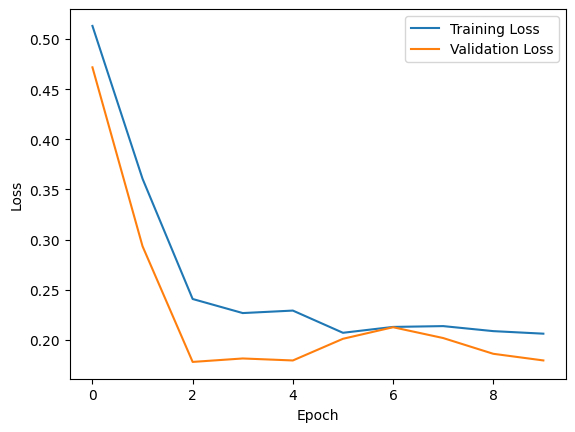

In [35]:
# Define callback functions
checkpoint_callback     = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_callback    = TensorBoard(log_dir='logs')

# Assuming X_train, y_true_train, X_val, y_true_val are your training and validation data
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
